# CSI 4142 Data Science
## Assignment 3 - Predictive analysis - Classification

### Identification
Name: Eli Wynn
Student Number: 300248135

Name: Jack Snelgrove
Student Number: 300247435

Our datasets have been uploaded from the public repository:

https://github.com/eli-wynn/Datasets

### Imports

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


### Dataset Overview
This dataset contains detailed records of simulated road accident data, focusing on factors influencing survival outcomes. The dataset includes demographic, behavioral, and situational attributes, providing valuable insights into how various factors impact the survival probability during road accidents.

#### Dataset Shape
- Rows: 200
- Columns: 6

#### Features and Descriptions
Below is a list of features included in the dataset along with their descriptions:

1. `Age` (Numerical)
- The age of the individual involved in the accident

2. `Gender` (Categorical)
- The gender of the individual involved in the accident 

3. `Speed of Impact` (Numerical)
- The speed the car was moving on impact

4. `Helmet used` (Categorical)
- Whether a helmet was used or not

5. `Seatbelt used` (Categorical)
- Whether a helmet was used or not

6. `Survived` (Numerical)
- Whether the individual survived or not

### Importing Dataset

In [99]:
crash  = "https://raw.githubusercontent.com/eli-wynn/Datasets/refs/heads/main/accident.csv"
crashData = pd.read_csv(crash)

#### Cleaning / Imputing Dataset

In [100]:
# Find columns with missing data
missing_cols = crashData.columns[crashData.isnull().any()]

# Impute missing Gender values with the mode
crashData.loc[:, 'Gender'] = crashData['Gender'].fillna(crashData['Gender'].mode()[0])

# Remove rows with missing 'Speed of Impact' values as this metric is crucial to the target
crashData = crashData.dropna(subset=['Speed_of_Impact'])

# Checking for valid age
crashData = crashData[(crashData['Age'] > 0) & (crashData['Age'] < 120)]

# Checking for valid gender
crashData = crashData[crashData['Gender'].isin(['Male', 'Female'])]

# Check for valid yes/no values
crashData = crashData[crashData['Helmet_Used'].isin(['Yes', 'No'])]
crashData = crashData[crashData['Seatbelt_Used'].isin(['Yes', 'No'])]

# Convert categorical values to numerical
crashData = crashData.assign(
    Gender=crashData['Gender'].map({'Male': 0, 'Female': 1}),
    Helmet_Used=crashData['Helmet_Used'].map({'No': 0, 'Yes': 1}),
    Seatbelt_Used=crashData['Seatbelt_Used'].map({'No': 0, 'Yes': 1})
)

crashData_baseline = crashData.copy(deep=True) #Make a copy of the df for later baseline comparison


### Outlier detection and handling (EDA and LOF)

I am performing EDA on only columns `Age` and `Speed of Impact` since they are the only columns that have numerical values that arent boolean therefore the only columns that could potentially contain 

#### Exploritary Data Analysis (EDA)

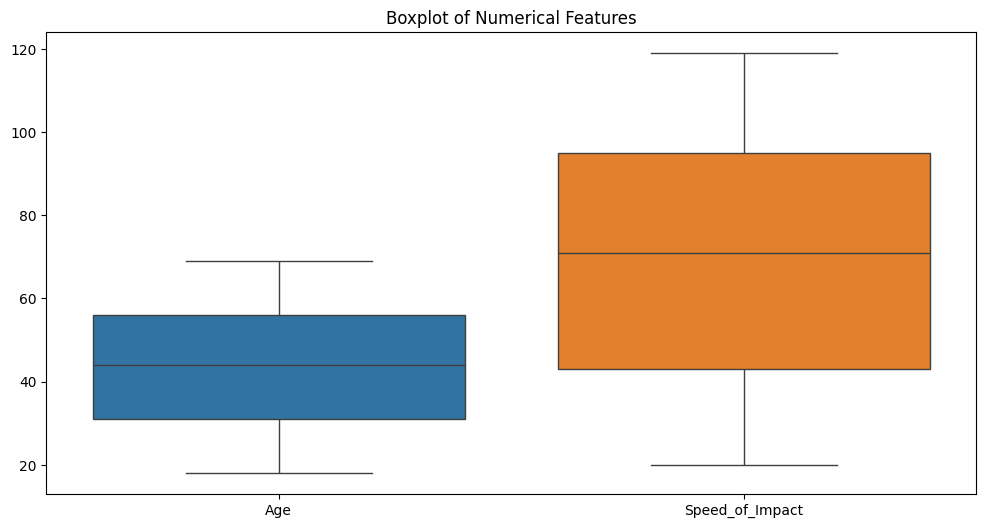

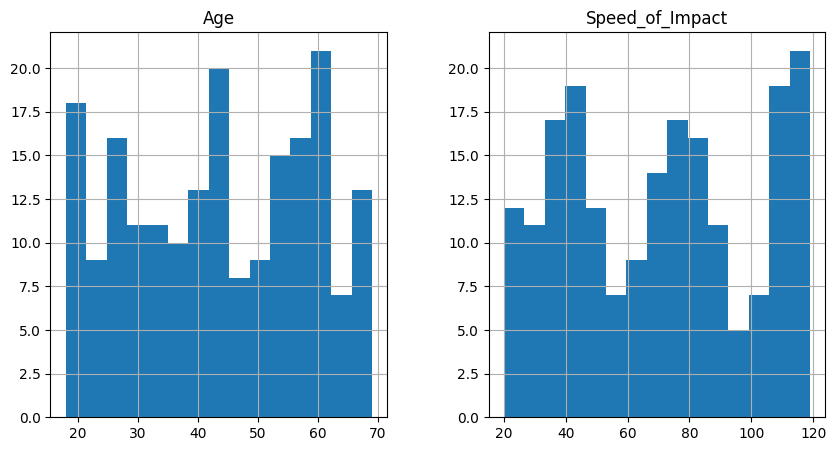

In [101]:

# Boxplot
plt.figure(figsize=(12,6))
sns.boxplot(data=crashData[['Age', 'Speed_of_Impact']])
plt.title("Boxplot of Numerical Features")
plt.show()

# Histogram
crashData[['Age', 'Speed_of_Impact']].hist(figsize=(10,5), bins=15)
plt.show()

From the plots above, we can see that `Age` and `Speed_of_Impact` do not exhibit extreme outliers. `Age` has already been cleaned to ensure values fall within 0-120, and the plots confirm a reasonable distribution without irregularities. `Speed_of_Impact`, however, shows a wider distribution with noticeable clustering at specific speed intervals. To detect potential localized outliers, I will apply LOF only to the `Speed_of_Impact` column.

#### Local Outlier Factor (LOF)

In [ ]:
feature_to_check = ['Speed_of_Impact']
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto') 
outlier_flags = lof.fit_predict(crashData[feature_to_check])  # Predict outliers

#Map flagged outliers to 1 and non-outliers to 0
crashData['LOF_Outlier'] = outlier_flags
crashData['LOF_Outlier'] = crashData['LOF_Outlier'].map({1: 0, -1: 1})

outliers = crashData[crashData['LOF_Outlier'] == 1]  # Filter outliers
crashData.drop(columns=['LOF_Outlier'], inplace=True)  # Remove LOF column


LOF was used to detect potential anomalies in `Speed_of_Impact` where 4 rows were identified as local outliers. However, these rows are not invalid and will remain in the dataset. 

### Decision Tree Classifier

In [ ]:
#Initialize a baseline model with deafault hyperparameters
baselineDTC= DecisionTreeClassifier()

#### Feature Engineering
1. Saftey score {0-2} combines `Helemt _Used` {0-1} and `Seatbelt_Used` {0-1} into one feature that represents the overall safey
2. Impact Severity {higher -> more severe, lower -> less severe} combines `Speed of Impact` and age to get a general severity score. We log transform these values since they are extreme. 

In [ ]:
#Append aggregated features
crashData['Safety_Score'] = crashData['Helmet_Used'] + crashData['Seatbelt_Used']
crashData['Impact_Severity'] = np.log1p(crashData['Speed_of_Impact'] ** 2 * crashData['Age'])

### Emphirical Study

In [ ]:
# a) Split df into 3 sets Train, Validation, Test

X = crashData.drop(columns=['Survived'])  # features
y = crashData['Survived']                 # target

#Train (70%) + Validation & Test (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

##Train (70%) + Validation (15%) & Test (15%)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# b) Evaluation metric choice is F1

# c) Baseline evaluation

#Separate features and target 
X_baseline = crashData_baseline.drop(columns=['Survived'])  
y_baseline = crashData_baseline['Survived']                 

# Use the same split indices from crashData for baseline split
X_train_baseline = X_baseline.loc[X_train.index]
X_valid_baseline = X_baseline.loc[X_valid.index]
X_test_baseline = X_baseline.loc[X_test.index]

y_train_baseline = y_baseline.loc[y_train.index]
y_valid_baseline = y_baseline.loc[y_valid.index]
y_test_baseline = y_baseline.loc[y_test.index]

# 4-Fold Cross-Validation 
f1 = cross_val_score(baselineDTC, X_valid_baseline, y_valid_baseline, cv=4, scoring='f1').mean()

print(f"Baseline F1-Score:  {f1:.4f}")

# d+c) Since I decided not to remove outliers, I will test the dataset with aggregations vs the dataset without while also changing the hyperparameters of the classifyer to find the best combination

# Define hyperparameter grid
criteria = ['gini', 'entropy']
max_depths = [None, 5, 10]
min_samples_splits = [2, 5, 10]

# Generate all combinations of hyperperameters
param_grid = list(itertools.product(criteria, max_depths, min_samples_splits))

# Datasets to compare
datasets = {
    "Baseline (No Feature Aggregation)": (X_valid_baseline, y_valid_baseline),
    "With Feature Aggregation": (X_valid, y_valid)  # Aggregated dataset
}

# Store results
results = []

# Loop dataset versions
for dataset_name, (X_val, y_val) in datasets.items():
    print(f"\nEvaluating: {dataset_name}")

    # Loop parameter combinations
    for criterion, max_depth, min_samples_split in param_grid:
        dt_model = DecisionTreeClassifier(
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )

        # 4-Fold Cross-Validation 
        f1 = cross_val_score(dt_model, X_val, y_val, cv=4, scoring='f1').mean()

        # Store result
        results.append((dataset_name, criterion, max_depth, min_samples_split, f1))
        print(f"Params: {criterion}, Depth={max_depth}, MinSamples={min_samples_split} → F1-Score: {f1:.4f}")# Generate all combinations
param_grid = list(itertools.product(criteria, max_depths, min_samples_splits))

#Convert the results to a dataframe
results_df = pd.DataFrame(results, columns=["Dataset", "Criterion", "Max Depth", "Min Samples Split", "F1-Score"])

# Identify best model
best_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]

# Best parameters
best_dataset = best_model["Dataset"]
best_criterion = best_model["Criterion"]
best_max_depth = int(best_model["Max Depth"])
best_min_samples_split = best_model["Min Samples Split"]

# Choose the correct dataset (Baseline or Feature Aggregation) based on best score
if best_dataset == "Baseline (No Feature Aggregation)":
    X_train_final, y_train_final = X_train_baseline, y_train_baseline
    X_test_final, y_test_final = X_test_baseline, y_test_baseline
else:
    X_train_final, y_train_final = X_train, y_train
    X_test_final, y_test_final = X_test, y_test

# Train the best Decision Tree model
final_model = DecisionTreeClassifier(
    criterion=best_criterion,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    random_state=42
)

#Fit the model with the data
final_model.fit(X_train_final, y_train_final) 

def evaluate_model(model, X_test, y_test):
    """Evaluates a trained model on the test set and prints all metrics."""
    
    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Results
    print(f"Best Model Evaluation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    

evaluate_model(final_model, X_test_final, y_test_final)




F1-Score:  0.4444

Evaluating: Baseline (No Feature Aggregation)
Params: gini, Depth=None, MinSamples=2 → F1-Score: 0.4524
Params: gini, Depth=None, MinSamples=5 → F1-Score: 0.4937
Params: gini, Depth=None, MinSamples=10 → F1-Score: 0.3353
Params: gini, Depth=5, MinSamples=2 → F1-Score: 0.4524
Params: gini, Depth=5, MinSamples=5 → F1-Score: 0.4937
Params: gini, Depth=5, MinSamples=10 → F1-Score: 0.3353
Params: gini, Depth=10, MinSamples=2 → F1-Score: 0.4524
Params: gini, Depth=10, MinSamples=5 → F1-Score: 0.4937
Params: gini, Depth=10, MinSamples=10 → F1-Score: 0.3353
Params: entropy, Depth=None, MinSamples=2 → F1-Score: 0.3333
Params: entropy, Depth=None, MinSamples=5 → F1-Score: 0.3353
Params: entropy, Depth=None, MinSamples=10 → F1-Score: 0.2381
Params: entropy, Depth=5, MinSamples=2 → F1-Score: 0.2778
Params: entropy, Depth=5, MinSamples=5 → F1-Score: 0.2798
Params: entropy, Depth=5, MinSamples=10 → F1-Score: 0.2381
Params: entropy, Depth=10, MinSamples=2 → F1-Score: 0.3333
Params:

### Results

#### a) Analyzing the Obtained Results & Improvements
We evaluated multiple Decision Tree settings and found the best performing combination. Below is a summary of the best F1-scores obtained in different scenarios:

| **Model**                          | **F1-Score (Validation)** | **F1-Score (Test Set)** | **Precision** | **Recall** |  
|------------------------------------|---------------------------|-------------------------|--------------|-----------|  
| **Baseline (No Aggregation)**       | **0.49**                   | **0.60**                 | **0.47**      | **0.82**   |  
| **With Feature Aggregation**        | **0.50**                   | **0.60**                 | **0.47**      | **0.82**   |  
| **Best Decision Tree Settings**     | **0.50**                   | **0.60**                 | **0.47**      | **0.82**   |   

##### Observations
- Feature Aggregation had minimal impact → The F1-score difference was negligible between baseline and feature aggregation.
- Hyperparameter tuning helped slightly, but the best improvement was minor.
- The test set score (0.60 F1) was higher than the validation score (0.50 F1), suggesting the model generalized slightly better than expected.

#### b) Impact of Outlier Detection & Feature Aggregation
##### Outlier Detection
- We decided not to remove outliers since they appeared to be realistic data points.
- No impact from outlier removal, since outliers were kept in the dataset.

##### Feature Aggregation
- We tested aggregated features like:
  - `Impact Severity = Speed² * Age`
  - `Safety Score = Helmet Used + Seatbelt Used`
- However, these new features did not significantly boost F1-score.
- Possible reason? The relationship between speed and survival may not be fully captured by a simple squared formula.

---

#### c) Cross-Validation vs. Test Set Results

| Metric  | Validation Set (Cross-Val) | Test Set (Final Evaluation) |
|------------|------------------------------|------------------------------|
| F1-Score  | 0.50                      | 0.60                     |
| Precision | 0.47                     | 0.47                      |
| Recall    | 0.81                      | 0.82                    |

##### Observations
1. Test Set performed slightly better than validation → This suggests the model generalized well.
2. Recall remained consistently high (0.82) → The model catches most true "Survived" cases.
3. Precision remained low (0.47) → High false positives indicate that the model predicts "Survived" too often.


### References
https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html